## 物件化管理
### RNN、GRU、SimpleRNN
### Y做正規化


In [4]:
import random
import datetime
import time
import pickle
import os
import math
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras import Sequential, Model   # 按順序建立的神經網路
from tensorflow.keras import metrics
from tensorflow.keras.layers import Dense,Conv2D,Dropout,Flatten,MaxPooling2D, LSTM, TimeDistributed,SimpleRNN # Dense全連線層
from tensorflow.keras.layers import RepeatVector,Input, Conv1D, Lambda, GRU, MaxPooling1D, multiply
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error,mean_squared_error
# confusion_matrix
from sklearn.metrics import classification_report
import itertools
from sklearn.metrics import confusion_matrix


In [2]:
class RNN_model_3C:        
    def __init__(self, rnn_type, L1_num, L2_num, batch_size, epochs):
        self.batch_size = batch_size
        self.epochs = epochs
        self.L1_num = L1_num
        self.L2_num = L2_num
        self.cm = None
        
        self.inputs = Input(shape=(3, 6))
        if rnn_type == "LSTM":
            self.lstm1 = LSTM(self.L1_num, activation='relu',return_sequences=True)(self.inputs)
            self.D1=Dropout(0.2)(self.lstm1)
            self.lstm2 = LSTM(self.L2_num, activation='relu',return_sequences=False)(self.D1)
            self.D2=Dropout(0.2)(self.lstm2)
            self.regression_layers= Dense(3, activation='softmax')(self.D2)
            
        if rnn_type == "GRU":
            self.GRU1 = GRU(self.L1_num, activation='relu',return_sequences=True)(self.inputs)
            self.D1=Dropout(0.2)(self.GRU1)
            self.GRU2 = LSTM(self.L2_num, activation='relu',return_sequences=False)(self.D1)
            self.D2=Dropout(0.2)(self.GRU2)
            self.regression_layers= Dense(3, activation='softmax')(self.D2)
            
        if rnn_type == "SimpleRNN":
            self.SimpleRNN1 = SimpleRNN(self.L1_num, activation='relu',return_sequences=True)(self.inputs)
            self.D1=Dropout(0.2)(self.SimpleRNN1)
            self.SimpleRNN2 = SimpleRNN(self.L2_num, activation='relu',return_sequences=False)(self.D1)
            self.D2=Dropout(0.2)(self.SimpleRNN2)
            self.regression_layers= Dense(3, activation='softmax')(self.D2)
            
        self.model = Model(self.inputs, self.regression_layers)
        self.early_stopping = EarlyStopping(monitor='val_loss', patience=5, verbose=2) 
        self.model.summary()    
        
    def training(self, trainX, trainY):
        start = time.time()
        self.model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=['accuracy'])
        history = self.model.fit(trainX, trainY, validation_split=0.1,
                                 batch_size=self.batch_size,
                                 epochs=self.epochs, verbose=1,
                                 callbacks=[self.early_stopping])
        end = time.time()
        print(start, end)
        print("執行時間：%f 秒" % (end - start))
        return history
        
    def plotLearningCurves2(self, history):
        df = pd.DataFrame(history.history)
        df.plot(figsize=(13,10))  
        plt.legend(markerscale=1000, fontsize=20)
        plt.grid(True) # 顯示網格
        plt.xlabel('epoch', fontsize = 20)  
        plt.ylabel('loss', fontsize = 20) 
        plt.title('Train History')
        plt.gca().set_ylim(0.2, 1)   
        plt.show()
        
    def make_predict(self, testX):     #不用inverse Y
        testX_pred=self.model.predict(testX)#預測testX
        return  testX_pred
            #       EX:  testX_pred = make_predict(data.testX)

    def eval(self, testX, testy):    
        accuracy = self.model.evaluate(testX, testy, batch_size=self.batch_size, verbose=0)         
        _, acc = self.model.evaluate(data.testX, testY, batch_size=128, verbose=0)
        return acc


    def plot_cm(self,testY, testX_pred_i_LSTM):
        from sklearn.metrics import classification_report,confusion_matrix
        y_pred=np.argmax(testX_pred_i_LSTM, axis=1)
        y_test=np.argmax(testY, axis=1)
        cm = confusion_matrix(y_test, y_pred)

        print(cm)
        print(classification_report(y_test,y_pred,digits=4))
        y_pred=np.argmax(testX_pred_i_LSTM, axis=1)
        y_test=np.argmax(testY, axis=1)
        cm = confusion_matrix(y_test, y_pred)

        class_names = ['1','2','3']
        plot_confusion_matrix(cm, class_names)
        plot_confusion_matrix(cm, class_names, normalize=False)
    
def plot_confusion_matrix( cm, classes=['1','2','3'],
                      normalize=True,
                      title='Confusion matrix',
                      cmap=plt.cm.Blues):   #plt.cm.Blues、plt.cm.bone_r
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    from sklearn.metrics import classification_report
    import itertools
    import matplotlib.pyplot as plt
    from sklearn.metrics import confusion_matrix
    import numpy as np
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)
    plt.figure(figsize = (7, 7))
    plt.imshow(cm, interpolation='none', cmap=cmap)
    plt.title(title,size=20)
    plt.colorbar(aspect=5)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45, size=18)
    plt.yticks(tick_marks, classes, size=18)

    fmt = '.4f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), fontsize=18,
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label',size=20)
    plt.xlabel('Predicted label',size=20)
    plt.tight_layout()

    



# 資料讀取建立
## X>>前normal過， Y_level3

In [27]:
import Dataset
#切train test# data.dataset_split(0.2,0.1,42)

data = Dataset.Data_set('Training', 'X.csv', 'Y_level3_05s.csv')
print(data.X_n_w.shape,data.Y.shape)

testdata = Dataset.Data_set('Testing','X.csv', 'Y_level3_05s.csv')
print(testdata.X_n_w.shape,testdata.Y.shape)

(878534, 18) (878534, 1)
被正規化後的形狀:  (878534, 18)
(878534, 3, 6) (878534, 1)


In [64]:
pd.DataFrame(trainX.reshape(-1,18)) #檢視

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17
0,0.555118,0.473333,0.544304,0.573708,0.012633,0.524104,0.622047,0.540000,0.497890,0.574864,0.015139,0.512609,0.645669,0.573333,0.523207,0.577492,0.011808,0.510229
1,0.622047,0.540000,0.497890,0.574864,0.015139,0.512609,0.645669,0.573333,0.523207,0.577492,0.011808,0.510229,0.622047,0.526667,0.523207,0.575564,0.014111,0.505980
2,0.645669,0.573333,0.523207,0.577492,0.011808,0.510229,0.622047,0.526667,0.523207,0.575564,0.014111,0.505980,0.622047,0.526667,0.523207,0.575564,0.014111,0.505980
3,0.622047,0.526667,0.523207,0.575564,0.014111,0.505980,0.622047,0.526667,0.523207,0.575564,0.014111,0.505980,0.622047,0.526667,0.523207,0.575564,0.014111,0.505980
4,0.622047,0.526667,0.523207,0.575564,0.014111,0.505980,0.622047,0.526667,0.523207,0.575564,0.014111,0.505980,0.622047,0.526667,0.523207,0.575564,0.014111,0.505980
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
878529,0.610236,0.466667,0.502110,0.721658,0.257025,0.379120,0.618110,0.453333,0.497890,0.734514,0.251764,0.375547,0.610236,0.413333,0.502110,0.731339,0.240456,0.375706
878530,0.618110,0.453333,0.497890,0.734514,0.251764,0.375547,0.610236,0.413333,0.502110,0.731339,0.240456,0.375706,0.633858,0.513333,0.502110,0.718442,0.274000,0.379191
878531,0.610236,0.413333,0.502110,0.731339,0.240456,0.375706,0.633858,0.513333,0.502110,0.718442,0.274000,0.379191,0.614173,0.473333,0.527426,0.718783,0.274122,0.378968
878532,0.633858,0.513333,0.502110,0.718442,0.274000,0.379191,0.614173,0.473333,0.527426,0.718783,0.274122,0.378968,0.637795,0.493333,0.485232,0.719131,0.274406,0.378862


In [28]:
#作one-hotincoding
from  keras.utils import to_categorical
# zero-offset class values  從0開始計類
trainX = data.X_n_w
trainY = data.Y - 1
# one hot encode y
trainY = to_categorical(trainY)
print(trainX.shape, trainY.shape)

testX = testdata.X_n_w
testY = testdata.Y - 1
# one hot encode y
testY = to_categorical(testY)
print(testX.shape, testY.shape)

(878534, 3, 6) (878534, 3)


In [29]:
# 檢視比例

unique, counts = np.unique(data.Y, return_counts=True)
print(dict(zip(unique, counts)));

{1: 267650, 2: 337298, 3: 273586}


# LSTM 模型

In [51]:
LSTM_model = RNN_model_3C("LSTM", 64, 16, 128, 100)  
#training
train_history_LSTM = LSTM_model.training(trainX, trainY)

Model: "model_37"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_38 (InputLayer)        [(None, 3, 6)]            0         
_________________________________________________________________
lstm_70 (LSTM)               (None, 3, 64)             18176     
_________________________________________________________________
dropout_74 (Dropout)         (None, 3, 64)             0         
_________________________________________________________________
lstm_71 (LSTM)               (None, 16)                5184      
_________________________________________________________________
dropout_75 (Dropout)         (None, 16)                0         
_________________________________________________________________
dense_37 (Dense)             (None, 3)                 51        
Total params: 23,411
Trainable params: 23,411
Non-trainable params: 0
______________________________________________________

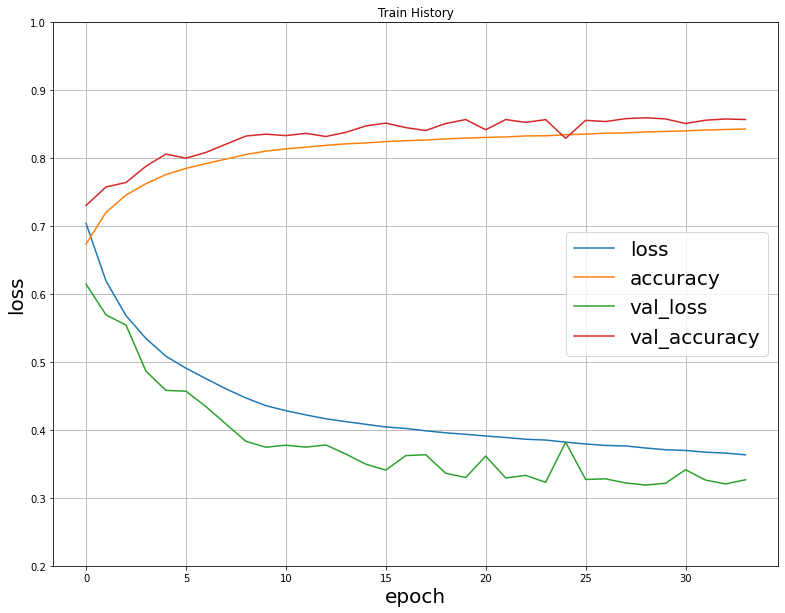

[[56365  7832     4]
 [ 6934 65416  5472]
 [    7  8906 57038]]
              precision    recall  f1-score   support

           0     0.8904    0.8779    0.8841     64201
           1     0.7963    0.8406    0.8178     77822
           2     0.9124    0.8649    0.8880     65951

    accuracy                         0.8598    207974
   macro avg     0.8663    0.8611    0.8633    207974
weighted avg     0.8621    0.8598    0.8605    207974

Normalized confusion matrix
[[8.77945826e-01 1.21991869e-01 6.23043255e-05]
 [8.91007684e-02 8.40584925e-01 7.03143070e-02]
 [1.06139407e-04 1.35039651e-01 8.64854210e-01]]
Confusion matrix, without normalization
[[56365  7832     4]
 [ 6934 65416  5472]
 [    7  8906 57038]]


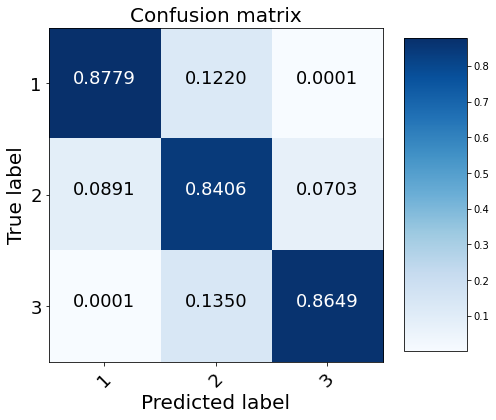

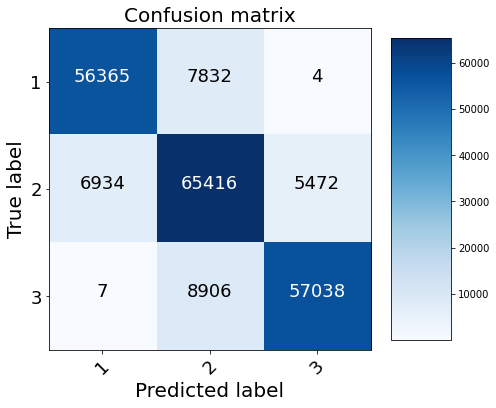

In [57]:
# acc = LSTM_model.eval(data.testX, testY)
# print('acc: ', acc)
# #畫出學習曲線
LSTM_model.plotLearningCurves2(train_history_LSTM)
# 預測pred
testX_pred_i_LSTM = LSTM_model.make_predict(testX)
# # plot cm
LSTM_model.plot_cm(testY, testX_pred_i_LSTM)


In [59]:
LSTM_model.model.save('trained_model/LSTM_model.h5')

## GRU模型

In [18]:
GRU_model = RNN_model_3C("GRU", 32, 16, 128, 100)  
#training
train_history_GRU = GRU_model.training(trainX, trainY)

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 3, 6)]            0         
_________________________________________________________________
gru_1 (GRU)                  (None, 3, 32)             3840      
_________________________________________________________________
dropout_6 (Dropout)          (None, 3, 32)             0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 16)                3136      
_________________________________________________________________
dropout_7 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 3)                 51        
Total params: 7,027
Trainable params: 7,027
Non-trainable params: 0
_________________________________________________________

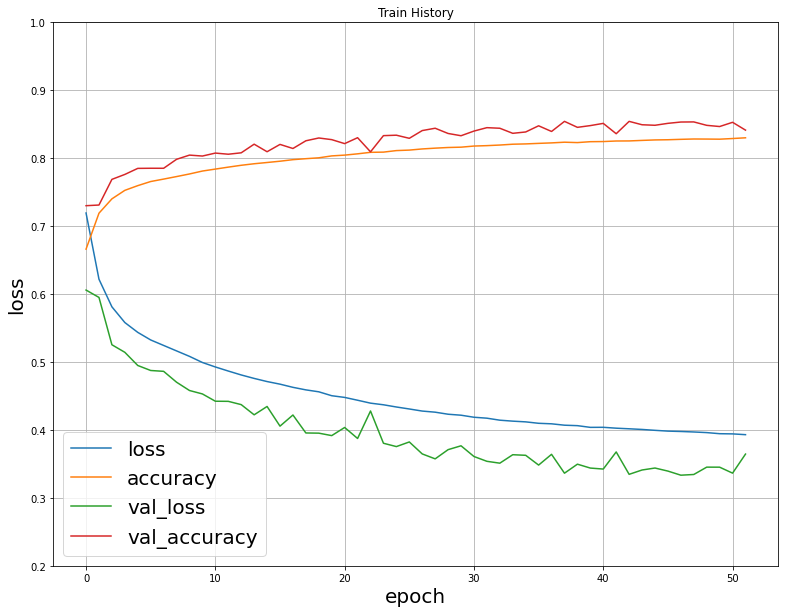

[[57327  6870     4]
 [ 9720 64653  3449]
 [   11 12680 53260]]
              precision    recall  f1-score   support

           0     0.8549    0.8929    0.8735     64201
           1     0.7678    0.8308    0.7981     77822
           2     0.9391    0.8076    0.8684     65951

    accuracy                         0.8426    207974
   macro avg     0.8539    0.8438    0.8466    207974
weighted avg     0.8490    0.8426    0.8436    207974

Normalized confusion matrix
[[8.92930017e-01 1.07007679e-01 6.23043255e-05]
 [1.24900414e-01 8.30780499e-01 4.43190871e-02]
 [1.66790496e-04 1.92263954e-01 8.07569256e-01]]
Confusion matrix, without normalization
[[57327  6870     4]
 [ 9720 64653  3449]
 [   11 12680 53260]]


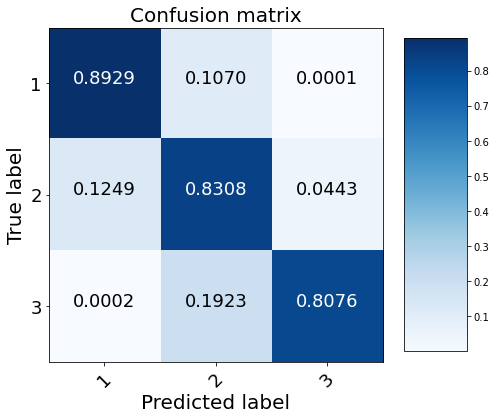

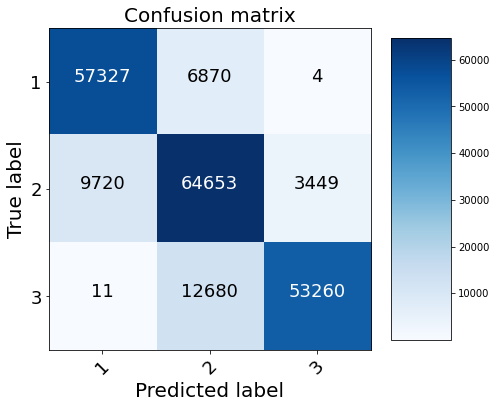

In [19]:
# acc = GRU_model.eval(testX, testY)
# print('acc: ', acc)
#畫出學習曲線
GRU_model.plotLearningCurves2(train_history_GRU)
# 預測pred
testX_pred_i_GRU = GRU_model.make_predict(testX)
# plot cm
GRU_model.plot_cm(testY, testX_pred_i_GRU)

In [ ]:
# GRU_model.model.save('trained_model/GRU_model.h5') 

# SIMPLE_RNN

In [15]:
SIMPLE_model = RNN_model_3C("SimpleRNN", 32, 16, 128, 100) 
#training|
train_history_SIM = SIMPLE_model.training(trainX, trainY)


Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 3, 6)]            0         
_________________________________________________________________
simple_rnn (SimpleRNN)       (None, 3, 32)             1248      
_________________________________________________________________
dropout_4 (Dropout)          (None, 3, 32)             0         
_________________________________________________________________
simple_rnn_1 (SimpleRNN)     (None, 16)                784       
_________________________________________________________________
dropout_5 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 3)                 51        
Total params: 2,083
Trainable params: 2,083
Non-trainable params: 0
_________________________________________________________

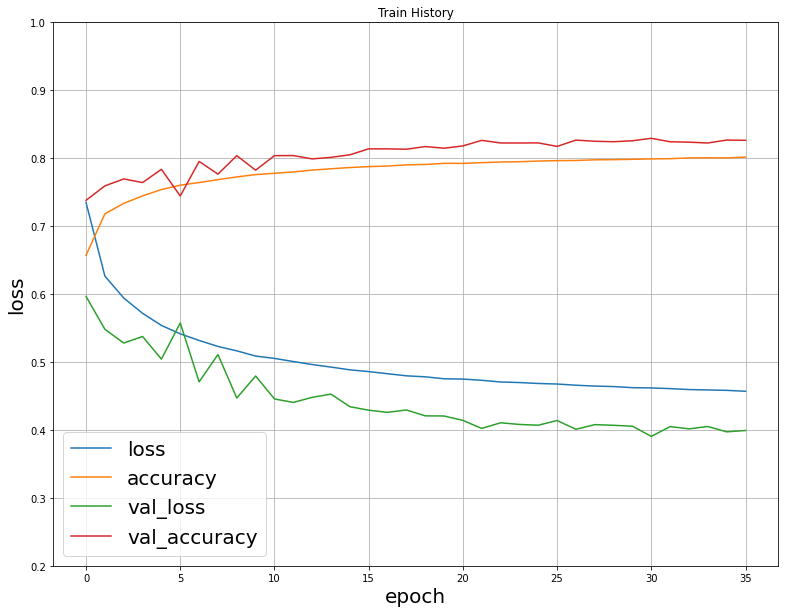

[[49643 14510    48]
 [ 4650 62663 10509]
 [   29  7581 58341]]
              precision    recall  f1-score   support

           0     0.9139    0.7732    0.8377     64201
           1     0.7394    0.8052    0.7709     77822
           2     0.8468    0.8846    0.8653     65951

    accuracy                         0.8205    207974
   macro avg     0.8333    0.8210    0.8246    207974
weighted avg     0.8273    0.8205    0.8214    207974

Normalized confusion matrix
[[7.73243407e-01 2.26008941e-01 7.47651906e-04]
 [5.97517412e-02 8.05209324e-01 1.35038935e-01]
 [4.39720398e-04 1.14948977e-01 8.84611302e-01]]
Confusion matrix, without normalization
[[49643 14510    48]
 [ 4650 62663 10509]
 [   29  7581 58341]]


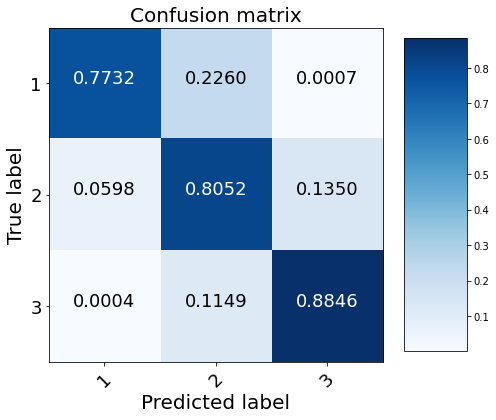

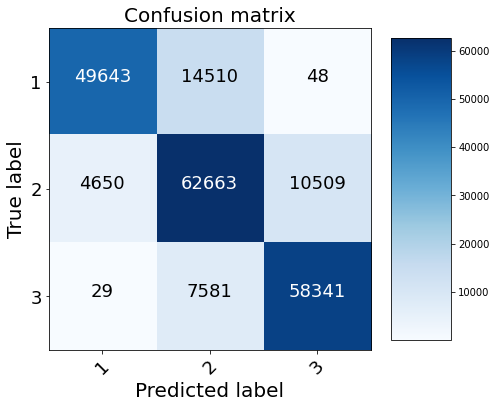

In [17]:
# acc = SIMPLE_model.eval(data.testX, testY)
# print('acc: ', acc)
# #畫出學習曲線
SIMPLE_model.plotLearningCurves2(train_history_SIM)
# 預測pred
testX_pred_i_SIM = SIMPLE_model.make_predict( testX)
# plot cm
SIMPLE_model.plot_cm(testY, testX_pred_i_GRU)

In [ ]:
# SIMPLE_model.model.save('trained_model/SIMPLE_model.h5') 

# CNN

In [70]:
from tensorflow.keras.models import load_model
import datetime
### 建模 EN-LSTM
start = time.time()


inputs = Input(shape=(3,6))

c1 = Conv1D(16,1 , activation="relu")(inputs)
c1 = Conv1D(8,1 , activation="relu")(c1)
p1 = MaxPooling1D(pool_size=2)(c1)

f = Flatten()(p1)
d = Dense(8, activation="relu")(f)
regression_layers = Dense(3, activation='softmax')(d)
CNN_model = Model(inputs, regression_layers)
CNN_model.compile(loss="categorical_crossentropy", optimizer="adam")
CNN_model.summary()

early_stopping = EarlyStopping(monitor='val_loss', patience=5, verbose=2) 
logdir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)


history_C_E = CNN_model.fit(trainX, trainY, validation_split=0.1, 
                        epochs=100, batch_size=128, verbose=1,
                           callbacks=[early_stopping,tensorboard_callback])



end = time.time()
print(start, end)
print("執行時間：%f 秒" % (end - start))



Model: "model_38"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_39 (InputLayer)        [(None, 3, 6)]            0         
_________________________________________________________________
conv1d (Conv1D)              (None, 3, 16)             112       
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 3, 8)              136       
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 1, 8)              0         
_________________________________________________________________
flatten (Flatten)            (None, 8)                 0         
_________________________________________________________________
dense_38 (Dense)             (None, 8)                 72        
_________________________________________________________________
dense_39 (Dense)             (None, 3)                 27 

[[51101 12988   112]
 [ 8742 59695  9385]
 [  166 12352 53433]]
              precision    recall  f1-score   support

           0     0.8516    0.7960    0.8228     64201
           1     0.7020    0.7671    0.7331     77822
           2     0.8491    0.8102    0.8292     65951

    accuracy                         0.7897    207974
   macro avg     0.8009    0.7911    0.7950    207974
weighted avg     0.7948    0.7897    0.7913    207974

Normalized confusion matrix
[[0.79595333 0.20230214 0.00174452]
 [0.11233327 0.76707101 0.12059572]
 [0.00251702 0.18729056 0.81019242]]
Confusion matrix, without normalization
[[51101 12988   112]
 [ 8742 59695  9385]
 [  166 12352 53433]]


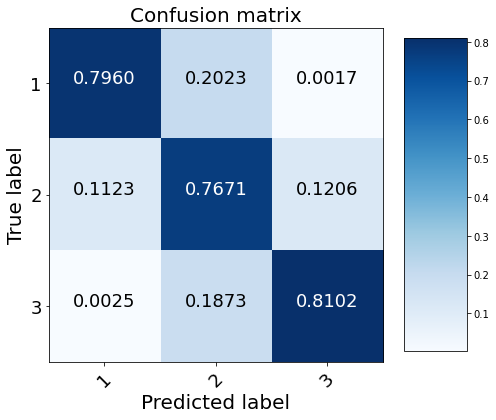

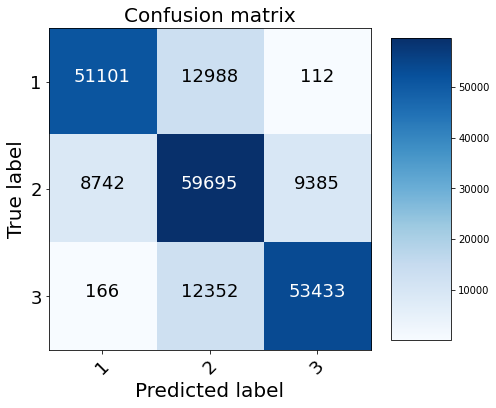

In [71]:
test_pred_CNN = CNN_model.predict(testX)

def plot_cm(Y, testX_pred_i_LSTM):
    from sklearn.metrics import classification_report,confusion_matrix
    y_pred=np.argmax(testX_pred_i_LSTM, axis=1)
    y_test=np.argmax(Y, axis=1)
    cm = confusion_matrix(y_test, y_pred)

    print(cm)
    print(classification_report(y_test,y_pred,digits=4))

    class_names = ['1','2','3']
    plot_confusion_matrix(cm, class_names)
    plot_confusion_matrix(cm, class_names, normalize=False)
    
plot_cm(testY, test_pred_CNN)


# RF

In [72]:
from sklearn.ensemble import RandomForestClassifier


start = time.time()


RF_model = RandomForestClassifier(n_estimators=100,n_jobs = -1,random_state =50, min_samples_leaf = 10)

# Y = data.trainY.reshape(-1)
trainX_r = trainX.reshape(-1,18)
testX_r = testX.reshape(-1,18)

history_RF = RF_model.fit(trainX_r,trainY )#,random_state=42

testX_pred_L=RF_model.predict(testX_r)#預測



end = time.time()
print(start, end)
print("執行時間：%f 秒" % (end - start))

from sklearn.metrics import classification_report,confusion_matrix

y_pred=np.argmax(testX_pred_L, axis=1)
y_test=np.argmax(testY, axis=1)
cm = confusion_matrix(y_test, y_pred)

print(cm)
print(classification_report(y_test,y_pred, digits=4))

1625469335.513312 1625469445.6537783
執行時間：110.140466 秒
[[58504  5697     0]
 [ 5264 69044  3514]
 [  885  5520 59546]]
              precision    recall  f1-score   support

           0     0.9049    0.9113    0.9081     64201
           1     0.8602    0.8872    0.8735     77822
           2     0.9443    0.9029    0.9231     65951

    accuracy                         0.8996    207974
   macro avg     0.9031    0.9004    0.9016    207974
weighted avg     0.9007    0.8996    0.8999    207974



[[58504  5697     0]
 [ 5264 69044  3514]
 [  885  5520 59546]]
              precision    recall  f1-score   support

           0     0.9049    0.9113    0.9081     64201
           1     0.8602    0.8872    0.8735     77822
           2     0.9443    0.9029    0.9231     65951

    accuracy                         0.8996    207974
   macro avg     0.9031    0.9004    0.9016    207974
weighted avg     0.9007    0.8996    0.8999    207974

Normalized confusion matrix
[[0.91126306 0.08873694 0.        ]
 [0.06764154 0.88720413 0.04515433]
 [0.01341905 0.0836985  0.90288244]]
Confusion matrix, without normalization
[[58504  5697     0]
 [ 5264 69044  3514]
 [  885  5520 59546]]


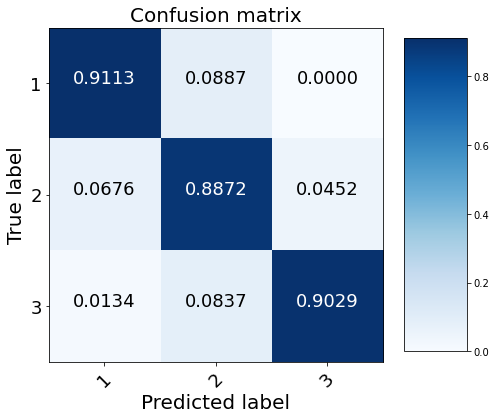

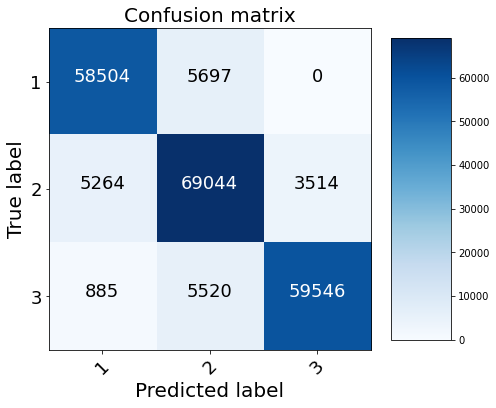

In [73]:
def plot_cm(testY, testX_pred_i_LSTM):
    from sklearn.metrics import classification_report,confusion_matrix
#     y_pred=np.argmax(testX_pred_i_LSTM, axis=1)
#     y_test=np.argmax(testY, axis=1)
    cm = confusion_matrix(testY, testX_pred_i_LSTM)

    print(cm)
    print(classification_report(testY,testX_pred_i_LSTM,digits=4))
#     y_pred=np.argmax(testX_pred_i_LSTM, axis=1)
#     y_test=np.argmax(testY, axis=1)
#     cm = confusion_matrix(y_test, y_pred)

    class_names = ['1','2','3']
    plot_confusion_matrix(cm, class_names)
    plot_confusion_matrix(cm, class_names, normalize=False)
    
plot_cm(y_test, y_pred)

In [75]:
import joblib

joblib.dump(RF_model, 'trained_model/RF_model_fromrnn')

['trained_model/RF_model_fromrnn']